In [1]:
import glob

import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import cartopy.crs as ccrs

from unseen import fileio

In [49]:
all_dry_years = np.array([1901, 1902, 1922, 1937, 1940, 1944, 1948, 1957, 1972, 1980, 1994, 2002, 2009, 2018, 2019])
all_wet_years = np.array([1917, 1920, 1921, 1931, 1955, 1958, 1963, 1971, 1973, 1974, 1975, 1978, 1988, 1999, 2011, 2016])

In [50]:
def detrend(da, dim, deg=1):
    """Linearly detrend along given dimension"""
    
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p['polyfit_coefficients'])
    fit_anom = fit - fit.isel({dim: 0})
    
    return da - fit_anom

In [87]:
def plot_data(fig, da, levels, cmap='viridis_r',
              nrows=1, ncols=1, index=1,
              polar=False):
    """Plot the data"""

    if (nrows == ncols == 1):
        colorbar = True
        cbar_kwargs = {'label': da.units}
    else:
        colorbar = False
        cbar_kwargs = {}    
        
    if polar:
        projection = ccrs.SouthPolarStereo(central_longitude=0)
    else:
        projection = ccrs.PlateCarree(central_longitude=180)
        
    ax = fig.add_subplot(nrows, ncols, index, projection=projection)
    if polar:
        ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
    ax.gridlines()
    im = da.plot.contourf(ax=ax,
                          levels=levels,
                          extend='both',
                          transform=ccrs.PlateCarree(),
                          cmap=cmap,
                          add_colorbar=colorbar,
                          cbar_kwargs=cbar_kwargs)
    ax.coastlines()
    
    return im

## SST

SST composites for Jan-Mar (ENSO) and Aug-Dec (IOD).

In [110]:
#sst_file = '/g/data/ua8/HadISST/v1-1/HadISST_sst.nc'
sst_file = '/Users/irv033/Downloads/HadISST_sst.nc'

In [111]:
#metadata_file = '/home/599/dbi599/unseen/config/dataset_hadisst.yml'
metadata_file = '/Users/irv033/Documents/code/unseen/config/dataset_hadisst.yml'
sst_ds = fileio.open_dataset(sst_file, metadata_file=metadata_file)

In [112]:
def is_jfm(month):
    """Is Jan-Mar season"""
    return month <= 3

def is_asond(month):
    "Is Aug-Dec season"
    return month >= 8

In [113]:
sst_JFM = sst_ds['sst'].sel({'time': is_jfm(sst_ds['time.month'])}).groupby('time.year').mean('time', keep_attrs=True)
sst_ASOND = sst_ds['sst'].sel({'time': is_asond(sst_ds['time.month'])}).groupby('time.year').mean('time', keep_attrs=True)

In [114]:
def calc_anomaly(da, base_period, detrend_data=False):
    """Calculate anomaly"""
    
    if detrend_data:
        data = detrend(da, 'year', deg=1)
    else:
        data = da
    
    start_year, end_year = base_period
    clim = data.sel({'year': slice(1971, 2000)}).mean('year', keep_attrs=True)
    anom = data - clim
    anom.attrs = da.attrs
    
    return anom

In [115]:
sst_JFM_anom = calc_anomaly(sst_JFM, [1971, 2000])
sst_JFM_anom_detrended = calc_anomaly(sst_JFM, [1971, 2000], detrend_data=True)

sst_ASOND_anom = calc_anomaly(sst_ASOND, [1971, 2000])
sst_ASOND_anom_detrended = calc_anomaly(sst_ASOND, [1971, 2000], detrend_data=True)

### Jan-Mar, dry years

#### Composite

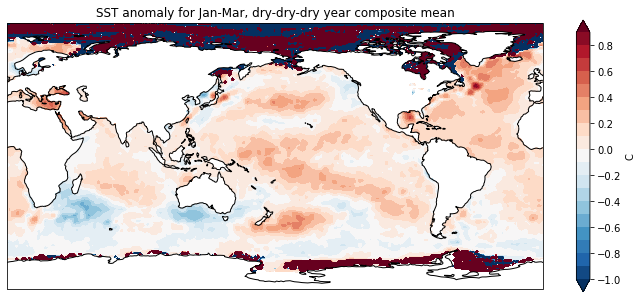

In [116]:
fig = plt.figure(figsize=[12,5])
plot_data(fig,
          sst_JFM_anom_detrended.sel(year=all_dry_years).mean('year', keep_attrs=True),
          np.arange(-1, 1, 0.1),
          cmap='RdBu_r')
plt.title('SST anomaly for Jan-Mar, dry-dry-dry year composite mean')
plt.savefig('sst_anom_JFM_dry-dry-dry_composite.png', bbox_inches='tight', facecolor='white')

#### Individual years

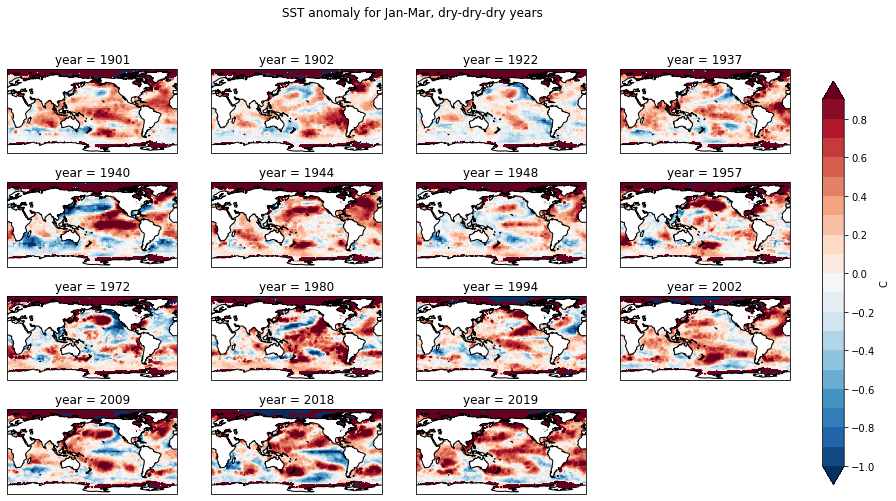

In [117]:
fig = plt.figure(figsize=[15, 8])  # width, height
nrows = 4
ncols = 4
for index, year in enumerate(all_dry_years):
    im = plot_data(fig,
                   sst_JFM_anom_detrended.sel(year=year),
                   np.arange(-1, 1, 0.1),
                   cmap='RdBu_r',
                   nrows=nrows,
                   ncols=ncols,
                   index=index + 1
                  )
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])  # l,b,w,h
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('C')
plt.suptitle('SST anomaly for Jan-Mar, dry-dry-dry years')
plt.savefig('sst_anom_JFM_dry-dry-dry.png', bbox_inches='tight', facecolor='white')

### Jan-Mar, wet years

#### Composite

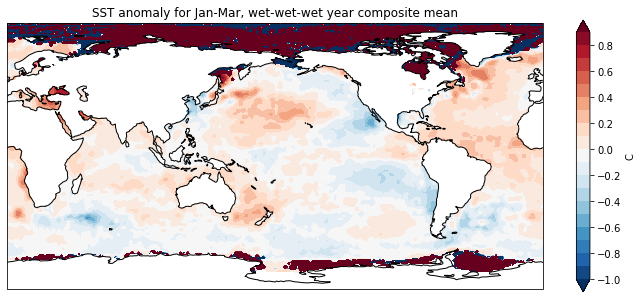

In [118]:
fig = plt.figure(figsize=[12,5])
plot_data(fig,
          sst_JFM_anom_detrended.sel(year=all_wet_years).mean('year', keep_attrs=True),
          np.arange(-1, 1, 0.1),
          cmap='RdBu_r')
plt.title('SST anomaly for Jan-Mar, wet-wet-wet year composite mean')
plt.savefig('sst_anom_JFM_wet-wet-wet_composite.png', bbox_inches='tight', facecolor='white')

#### Individual years

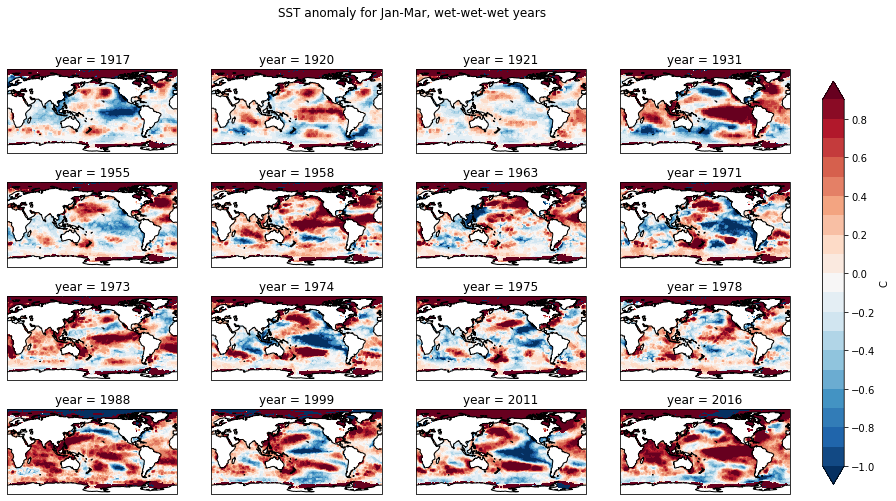

In [119]:
fig = plt.figure(figsize=[15, 8])  # width, height
nrows = 4
ncols = 4
for index, year in enumerate(all_wet_years):
    im = plot_data(fig,
                   sst_JFM_anom_detrended.sel(year=year),
                   np.arange(-1, 1, 0.1),
                   cmap='RdBu_r',
                   nrows=nrows,
                   ncols=ncols,
                   index=index + 1
                  )
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])  # l,b,w,h
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('C')
plt.suptitle('SST anomaly for Jan-Mar, wet-wet-wet years')
plt.savefig('sst_anom_JFM_wet-wet-wet.png', bbox_inches='tight', facecolor='white')

### Aug-Dec, dry years

#### Composite

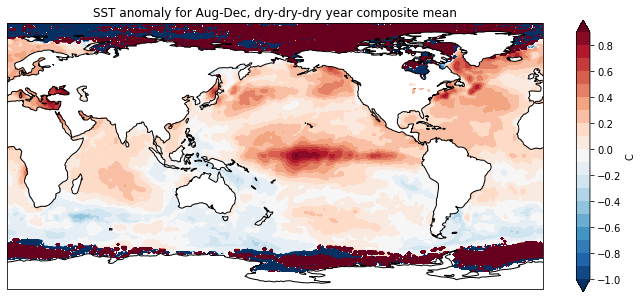

In [120]:
fig = plt.figure(figsize=[12,5])
plot_data(fig,
          sst_ASOND_anom_detrended.sel(year=all_dry_years).mean('year', keep_attrs=True),
          np.arange(-1, 1, 0.1),
          cmap='RdBu_r')
plt.title('SST anomaly for Aug-Dec, dry-dry-dry year composite mean')
plt.savefig('sst_anom_ASOND_dry-dry-dry_composite.png', bbox_inches='tight', facecolor='white')

#### Individual years

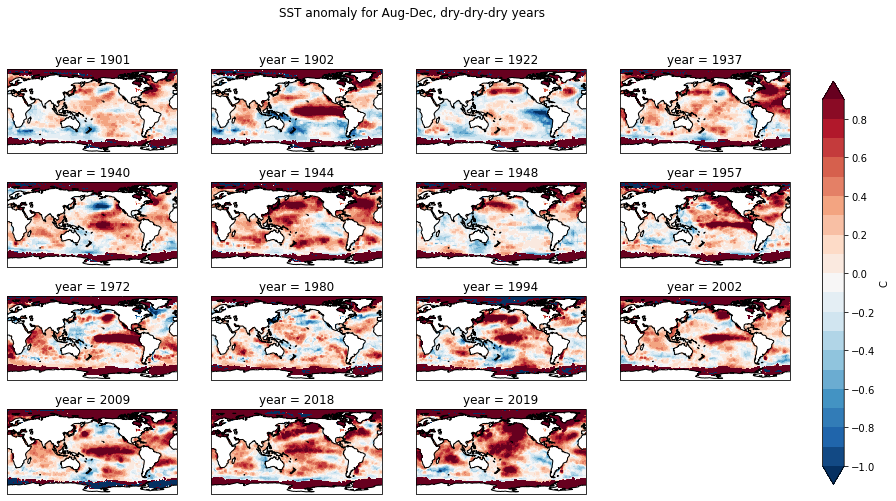

In [121]:
fig = plt.figure(figsize=[15, 8])  # width, height
nrows = 4
ncols = 4
for index, year in enumerate(all_dry_years):
    im = plot_data(fig,
                   sst_ASOND_anom_detrended.sel(year=year),
                   np.arange(-1, 1, 0.1),
                   cmap='RdBu_r',
                   nrows=nrows,
                   ncols=ncols,
                   index=index + 1
                  )
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])  # l,b,w,h
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('C')
plt.suptitle('SST anomaly for Aug-Dec, dry-dry-dry years')
plt.savefig('sst_anom_ASOND_dry-dry-dry.png', bbox_inches='tight', facecolor='white')

### Aug-Dec, wet years

#### Composite

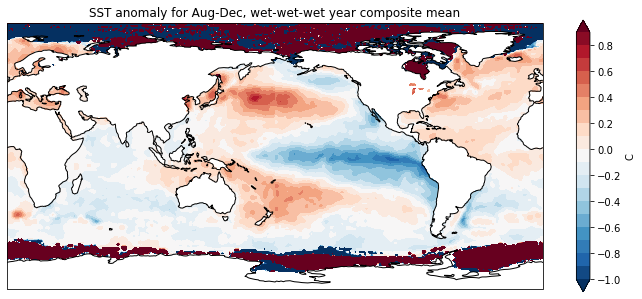

In [122]:
fig = plt.figure(figsize=[12, 5])
plot_data(fig,
          sst_ASOND_anom_detrended.sel(year=all_wet_years).mean('year', keep_attrs=True),
          np.arange(-1, 1, 0.1),
          cmap='RdBu_r')
plt.title('SST anomaly for Aug-Dec, wet-wet-wet year composite mean')
plt.savefig('sst_anom_ASOND_wet-wet-wet_composite.png', bbox_inches='tight', facecolor='white')

#### Individual years

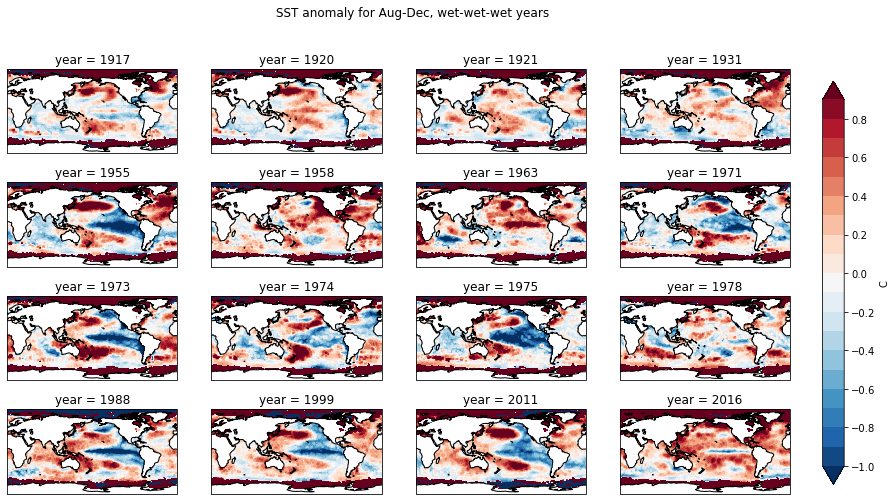

In [123]:
fig = plt.figure(figsize=[15, 8])  # width, height
nrows = 4
ncols = 4
for index, year in enumerate(all_wet_years):
    im = plot_data(fig,
                   sst_ASOND_anom_detrended.sel(year=year),
                   np.arange(-1, 1, 0.1),
                   cmap='RdBu_r',
                   nrows=nrows,
                   ncols=ncols,
                   index=index + 1
                  )
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])  # l,b,w,h
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('C')
plt.suptitle('SST anomaly for Aug-Dec, wet-wet-wet years')
plt.savefig('sst_anom_ASOND_wet-wet-wet.png', bbox_inches='tight', facecolor='white')

## Z500

Z500 anomaly composites for MAM, JJA, SON (to indicate what the SAM is doing).

In [2]:
era5_files = glob.glob('/g/data/rt52/era5/pressure-levels/monthly-averaged/z/*/z_era5_moda_pl_*.nc')
era5_files.sort()
era5_files

['/g/data/rt52/era5/pressure-levels/monthly-averaged/z/1979/z_era5_moda_pl_19790101-19790131.nc',
 '/g/data/rt52/era5/pressure-levels/monthly-averaged/z/1979/z_era5_moda_pl_19790201-19790228.nc',
 '/g/data/rt52/era5/pressure-levels/monthly-averaged/z/1979/z_era5_moda_pl_19790301-19790331.nc',
 '/g/data/rt52/era5/pressure-levels/monthly-averaged/z/1979/z_era5_moda_pl_19790401-19790430.nc',
 '/g/data/rt52/era5/pressure-levels/monthly-averaged/z/1979/z_era5_moda_pl_19790501-19790531.nc',
 '/g/data/rt52/era5/pressure-levels/monthly-averaged/z/1979/z_era5_moda_pl_19790601-19790630.nc',
 '/g/data/rt52/era5/pressure-levels/monthly-averaged/z/1979/z_era5_moda_pl_19790701-19790731.nc',
 '/g/data/rt52/era5/pressure-levels/monthly-averaged/z/1979/z_era5_moda_pl_19790801-19790831.nc',
 '/g/data/rt52/era5/pressure-levels/monthly-averaged/z/1979/z_era5_moda_pl_19790901-19790930.nc',
 '/g/data/rt52/era5/pressure-levels/monthly-averaged/z/1979/z_era5_moda_pl_19791001-19791031.nc',
 '/g/data/rt52/era5/

In [18]:
era5_ds = fileio.open_dataset(era5_files,
                              metadata_file='/home/599/dbi599/unseen/config/dataset_era5_monthly.yml',
                              variables=['z'],
                              input_freq='M',
                              time_freq='Q-NOV',
                              time_agg='mean',
                              sel={'level': 500, 'lat': slice(0, -90)})

In [19]:
era5_ds = era5_ds.compute()

In [21]:
z500 = era5_ds['z'] / 9.80665

In [22]:
z500_clim = z500.groupby('time.season').mean('time')

In [24]:
z500_anom = z500.groupby('time.season') - z500_clim

In [46]:
z500_MAM = z500_anom.sel(time=z500_anom['season'] == 'MAM').groupby('time.year').mean('time')
z500_JJA = z500_anom.sel(time=z500_anom['season'] == 'JJA').groupby('time.year').mean('time')
z500_SON = z500_anom.sel(time=z500_anom['season'] == 'SON').groupby('time.year').mean('time')

In [65]:
z500_MAM.attrs = {'units': 'm'}
z500_JJA.attrs = {'units': 'm'}
z500_SON.attrs = {'units': 'm'}

In [59]:
all_dry_years[-6:]

array([1980, 1994, 2002, 2009, 2018, 2019])

In [64]:
all_wet_years[-4:]

array([1988, 1999, 2011, 2016])

### MAM

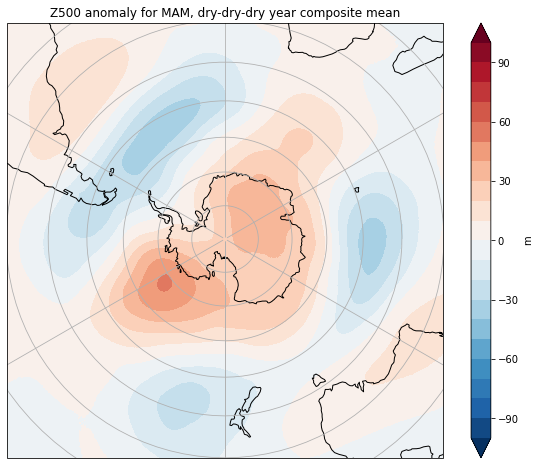

In [101]:
fig = plt.figure(figsize=[10, 8])
plot_data(fig,
          z500_MAM.sel(year=all_dry_years[-6:]).mean('year', keep_attrs=True),
          np.arange(-100, 101, 10),
          cmap='RdBu_r',
          polar=True)
plt.title('Z500 anomaly for MAM, dry-dry-dry year composite mean')
plt.savefig('/g/data/xv83/dbi599/wheatbelt/z500_anom_MAM_dry-dry-dry_composite.png',
            bbox_inches='tight', facecolor='white')

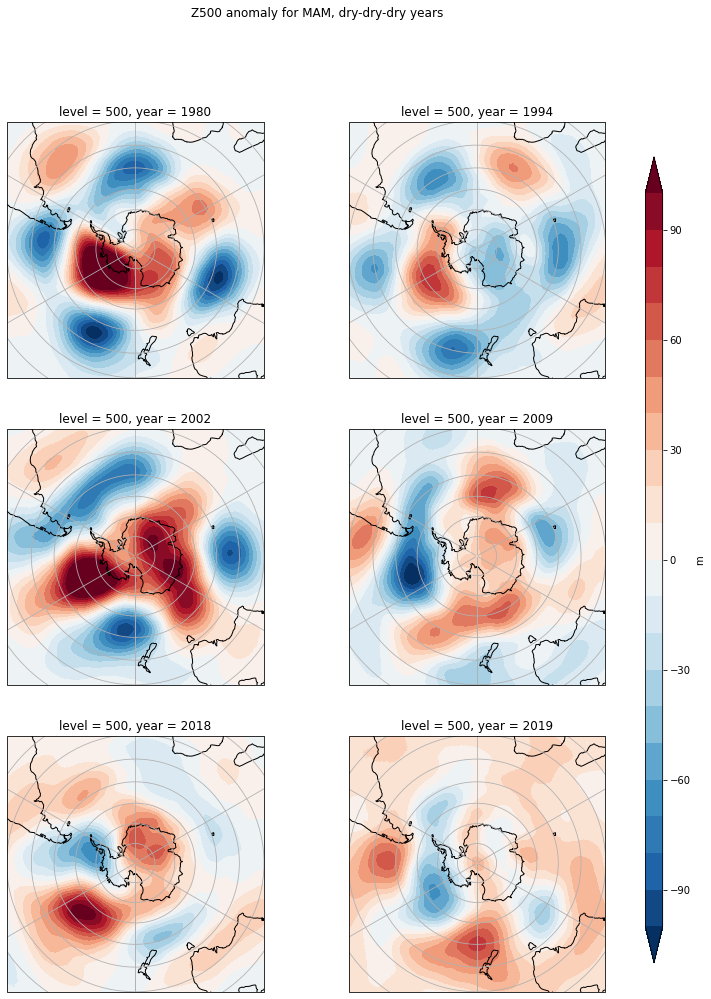

In [102]:
fig = plt.figure(figsize=[12, 16])  # width, height
nrows = 3
ncols = 2
for index, year in enumerate(all_dry_years[-6:]):
    im = plot_data(fig,
                   z500_MAM.sel(year=year),
                   np.arange(-100, 101, 10),
                   cmap='RdBu_r',
                   nrows=nrows,
                   ncols=ncols,
                   index=index + 1,
                   polar=True
                  )
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])  # l,b,w,h
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('m')
plt.suptitle('Z500 anomaly for MAM, dry-dry-dry years')
plt.savefig('/g/data/xv83/dbi599/wheatbelt/z500_anom_MAM_dry-dry-dry.png',
            bbox_inches='tight', facecolor='white')

## JJA

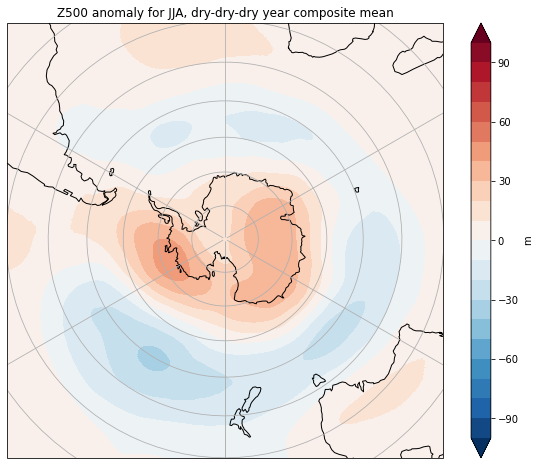

In [103]:
fig = plt.figure(figsize=[10, 8])
plot_data(fig,
          z500_JJA.sel(year=all_dry_years[-6:]).mean('year', keep_attrs=True),
          np.arange(-100, 101, 10),
          cmap='RdBu_r',
          polar=True)
plt.title('Z500 anomaly for JJA, dry-dry-dry year composite mean')
plt.savefig('/g/data/xv83/dbi599/wheatbelt/z500_anom_JJA_dry-dry-dry_composite.png',
            bbox_inches='tight', facecolor='white')

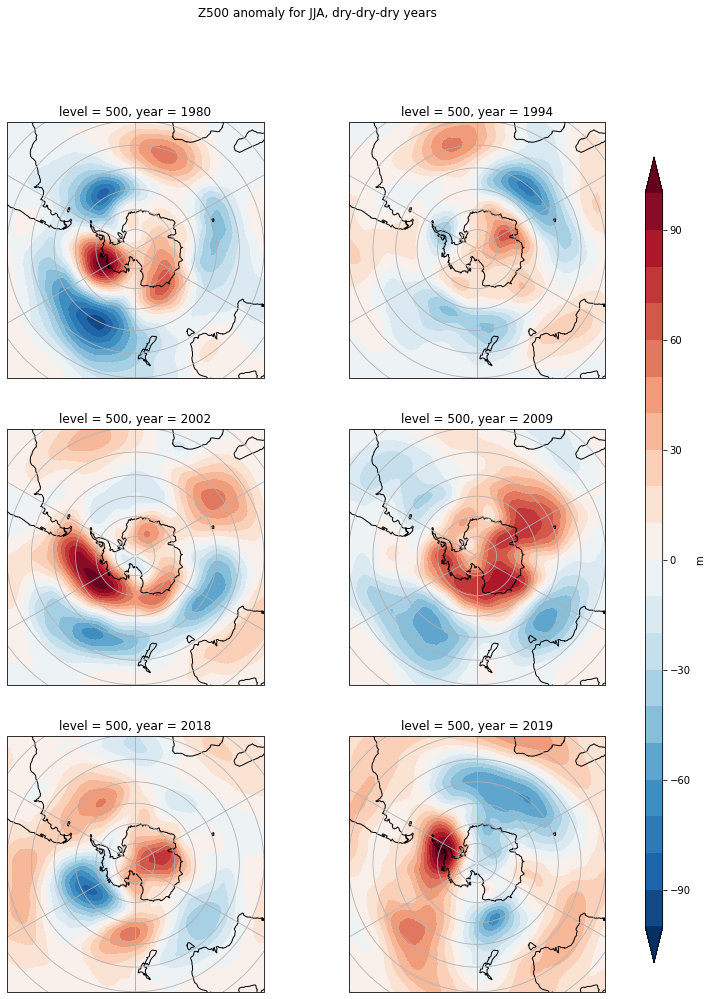

In [104]:
fig = plt.figure(figsize=[12, 16])  # width, height
nrows = 3
ncols = 2
for index, year in enumerate(all_dry_years[-6:]):
    im = plot_data(fig,
                   z500_JJA.sel(year=year),
                   np.arange(-100, 101, 10),
                   cmap='RdBu_r',
                   nrows=nrows,
                   ncols=ncols,
                   index=index + 1,
                   polar=True
                  )
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])  # l,b,w,h
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('m')
plt.suptitle('Z500 anomaly for JJA, dry-dry-dry years')
plt.savefig('/g/data/xv83/dbi599/wheatbelt/z500_anom_JJA_dry-dry-dry.png',
            bbox_inches='tight', facecolor='white')

## SON

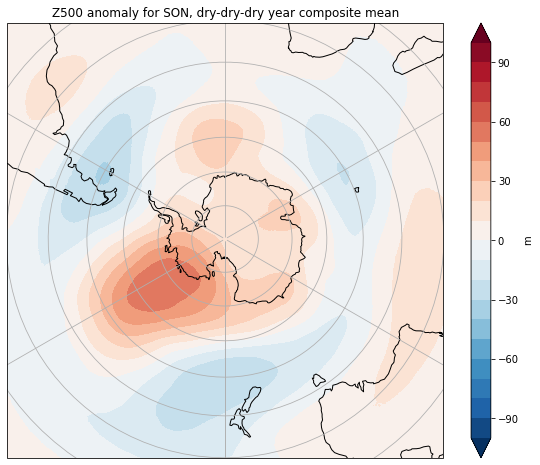

In [105]:
fig = plt.figure(figsize=[10, 8])
plot_data(fig,
          z500_SON.sel(year=all_dry_years[-6:]).mean('year', keep_attrs=True),
          np.arange(-100, 101, 10),
          cmap='RdBu_r',
          polar=True)
plt.title('Z500 anomaly for SON, dry-dry-dry year composite mean')
plt.savefig('/g/data/xv83/dbi599/wheatbelt/z500_anom_SON_dry-dry-dry_composite.png',
            bbox_inches='tight', facecolor='white')

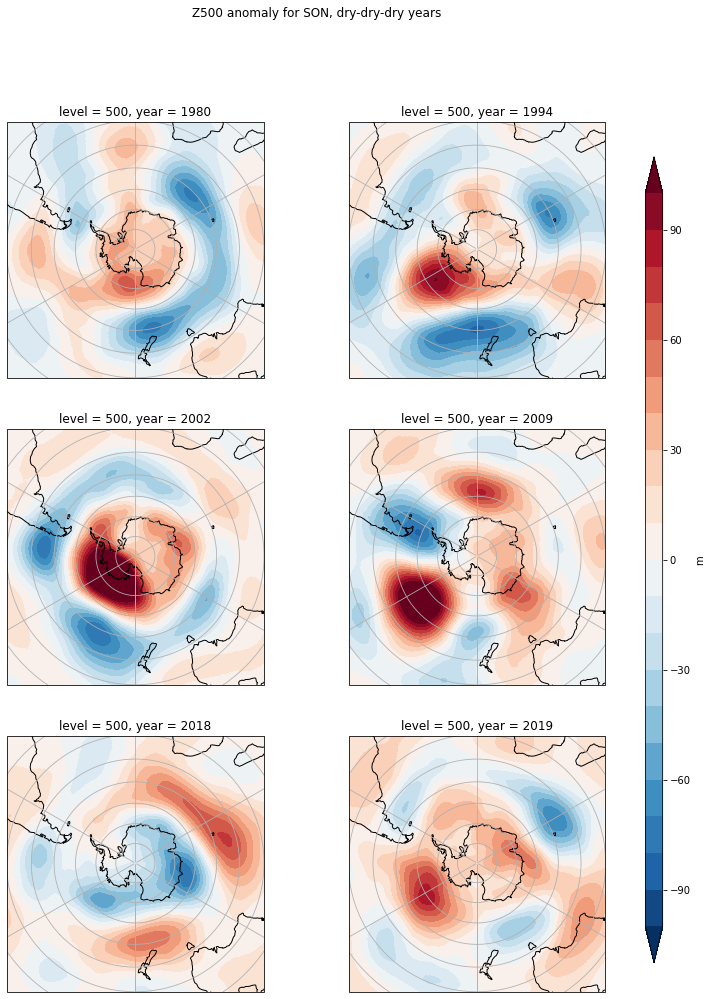

In [106]:
fig = plt.figure(figsize=[12, 16])  # width, height
nrows = 3
ncols = 2
for index, year in enumerate(all_dry_years[-6:]):
    im = plot_data(fig,
                   z500_SON.sel(year=year),
                   np.arange(-100, 101, 10),
                   cmap='RdBu_r',
                   nrows=nrows,
                   ncols=ncols,
                   index=index + 1,
                   polar=True
                  )
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])  # l,b,w,h
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('m')
plt.suptitle('Z500 anomaly for SON, dry-dry-dry years')
plt.savefig('/g/data/xv83/dbi599/wheatbelt/z500_anom_SON_dry-dry-dry.png',
            bbox_inches='tight', facecolor='white')